# **Build a Dataset Class for Horse Breeds**

https://www.kaggle.com/datasets/olgabelitskaya/horse-breeds

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("olgabelitskaya/horse-breeds")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'horse-breeds' dataset.
Path to dataset files: /kaggle/input/horse-breeds


### Imports

In [2]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from torchvision import models


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Split the data into train val, and test set (starified)

In [3]:
img_dir = path
img_files = sorted([f for f in os.listdir(img_dir) if f.endswith('.png')])

breed_names = ['Akhal-Teke', 'Appaloosa', 'Orlov Trotter', 
               'Vladimir Heavy Draft', 'Percheron', 'Arabian', 'Friesian']

labels = [int(f[:2]) - 1 for f in img_files]
df = pd.DataFrame({'filename': img_files, 'label': labels})

train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

print(f'Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}')
print(f'Train distribution:\n{train_df["label"].value_counts().sort_index()}')

Train: 536, Val: 67, Test: 67
Train distribution:
label
0    98
1    84
2    86
3    30
4    45
5    97
6    96
Name: count, dtype: int64


### Dataset Class

In [4]:
class HorseDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.df.iloc[idx]['filename'])
        image = Image.open(img_path).convert('RGB')
        label = self.df.iloc[idx]['label']
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

### Transforms

In [5]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

### Create Dataloader objects

In [6]:
batch_size = 32

train_dataset = HorseDataset(train_df, img_dir, train_transform)
val_dataset = HorseDataset(val_df, img_dir, val_test_transform)
test_dataset = HorseDataset(test_df, img_dir, val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f'Train batches: {len(train_loader)}, Val batches: {len(val_loader)}, Test batches: {len(test_loader)}')

Train batches: 17, Val batches: 3, Test batches: 3


#### Display some images

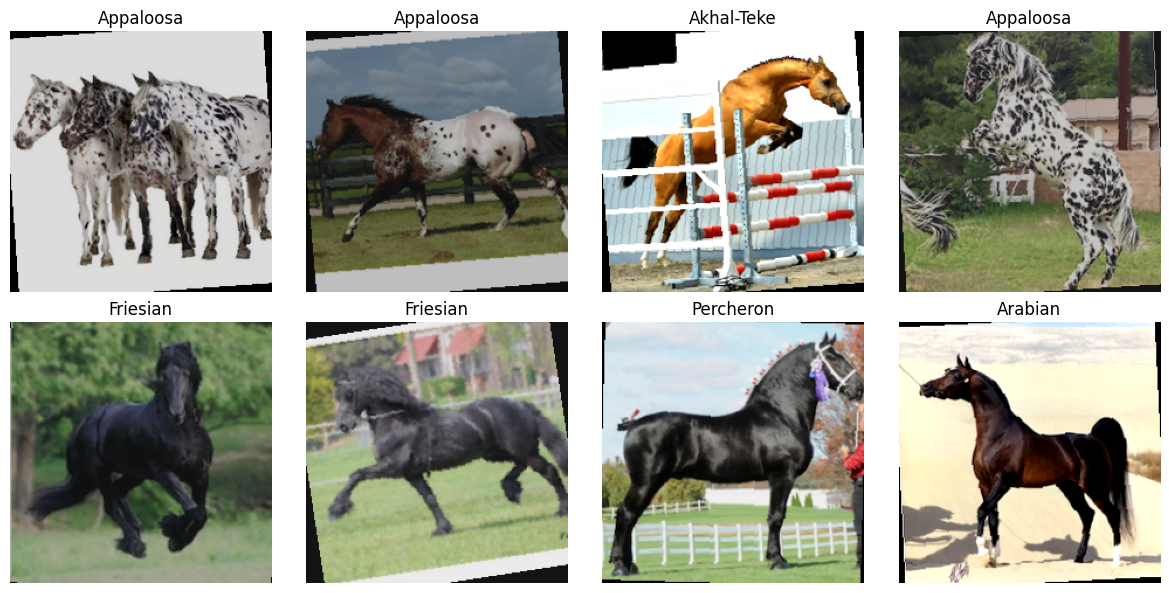

In [7]:
def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return tensor * std + mean

images, labels = next(iter(train_loader))

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for idx, ax in enumerate(axes.flat):
    img = denormalize(images[idx]).permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    ax.imshow(img)
    ax.set_title(breed_names[labels[idx]])
    ax.axis('off')
plt.tight_layout()
plt.show()

### Define Model 

In [8]:
class HorseCNN(nn.Module):
    def __init__(self, num_classes):
        super(HorseCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(2, 2)
        
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(256 * 14 * 14, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu(self.bn3(self.conv3(x))))
        x = self.pool4(self.relu(self.bn4(self.conv4(x))))
        
        x = self.flatten(x)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        
        return x

num_classes = 7
model = HorseCNN(num_classes)
model = model.to(device)

### define Loss and Optimizer

In [9]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

#### Build one_epoch_training function loop 

In [10]:
def one_epoch_training(model, train_loader, loss_function, optimizer, device):
    model.train()
    running_train_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item() * images.size(0)
        
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    epoch_train_accuracy = 100.0 * correct / total
    
    return epoch_train_loss, epoch_train_accuracy

#### Build one_epoch_validation function loop 

In [11]:
def one_epoch_validation(model, val_loader, loss_function, device):
    model.eval()
    running_val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            val_loss = loss_function(outputs, labels)
            
            running_val_loss += val_loss.item() * images.size(0)
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    epoch_val_accuracy = 100.0 * correct / total
    
    return epoch_val_loss, epoch_val_accuracy

### Combine all to train the model
it should Save the best model and track train and val loss and accuracy


In [12]:
def train_model(
    model,
    train_loader,
    val_loader,
    loss_function,
    optimizer,
    num_epochs,
    device,
    save_path="best_model_checkpoint.pth"
):
    model.to(device)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_val_accuracy = 0.0

    print("=== Training Started ===")

    for epoch in range(num_epochs):
        train_loss, train_acc = one_epoch_training(
            model, train_loader, loss_function, optimizer, device
        )

        val_loss, val_acc = one_epoch_validation(
            model, val_loader, loss_function, device
        )

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(
            f"Epoch [{epoch+1}/{num_epochs}] | "
            f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%"
        )

        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc

            checkpoint = {
                "epoch": epoch + 1,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "best_val_accuracy": best_val_accuracy
            }

            torch.save(checkpoint, save_path)

            print(f"✔ Best model saved (Val Acc = {best_val_accuracy:.2f}%)")

    print("=== Training Finished ===")

    return {
        "train_loss": train_losses,
        "val_loss": val_losses,
        "train_accuracy": train_accuracies,
        "val_accuracy": val_accuracies
    }

In [13]:
num_epochs = 25

history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_function=loss_function,
    optimizer=optimizer,
    num_epochs=num_epochs,
    device=device
)

=== Training Started ===
Epoch [1/25] | Train Loss: 15.9094, Train Acc: 23.69% | Val Loss: 3.3699, Val Acc: 35.82%
✔ Best model saved (Val Acc = 35.82%)
Epoch [2/25] | Train Loss: 3.5109, Train Acc: 38.62% | Val Loss: 1.3710, Val Acc: 41.79%
✔ Best model saved (Val Acc = 41.79%)
Epoch [3/25] | Train Loss: 1.6813, Train Acc: 39.74% | Val Loss: 1.4552, Val Acc: 46.27%
✔ Best model saved (Val Acc = 46.27%)
Epoch [4/25] | Train Loss: 1.4812, Train Acc: 45.52% | Val Loss: 1.3590, Val Acc: 41.79%
Epoch [5/25] | Train Loss: 1.3340, Train Acc: 50.19% | Val Loss: 1.2801, Val Acc: 50.75%
✔ Best model saved (Val Acc = 50.75%)
Epoch [6/25] | Train Loss: 1.4010, Train Acc: 47.76% | Val Loss: 1.2739, Val Acc: 49.25%
Epoch [7/25] | Train Loss: 1.2803, Train Acc: 52.43% | Val Loss: 1.3137, Val Acc: 50.75%
Epoch [8/25] | Train Loss: 1.3520, Train Acc: 52.80% | Val Loss: 1.4088, Val Acc: 46.27%
Epoch [9/25] | Train Loss: 1.2449, Train Acc: 53.54% | Val Loss: 1.1705, Val Acc: 58.21%
✔ Best model saved (V

### Load Best trained model

In [14]:
num_classes = 7
model = HorseCNN(num_classes)
checkpoint = torch.load("/content/best_model_checkpoint.pth", map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(device)
model.eval()

HorseCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

### test the model on test set

Classification Report:

                      precision    recall  f1-score   support

          Akhal-Teke       0.50      0.58      0.54        12
           Appaloosa       1.00      0.90      0.95        10
       Orlov Trotter       0.60      0.55      0.57        11
Vladimir Heavy Draft       0.00      0.00      0.00         4
           Percheron       0.00      0.00      0.00         6
             Arabian       0.73      0.67      0.70        12
            Friesian       0.55      1.00      0.71        12

            accuracy                           0.63        67
           macro avg       0.48      0.53      0.49        67
        weighted avg       0.57      0.63      0.58        67



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


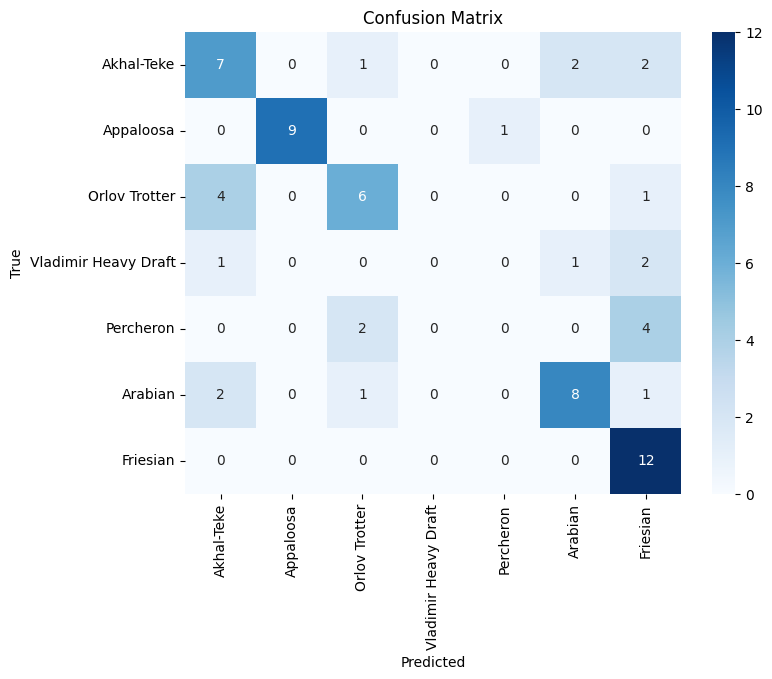

In [15]:
breed_names = ['Akhal-Teke', 'Appaloosa', 'Orlov Trotter', 
               'Vladimir Heavy Draft', 'Percheron', 'Arabian', 'Friesian']

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=breed_names))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=breed_names, yticklabels=breed_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

### show some predictions with the images

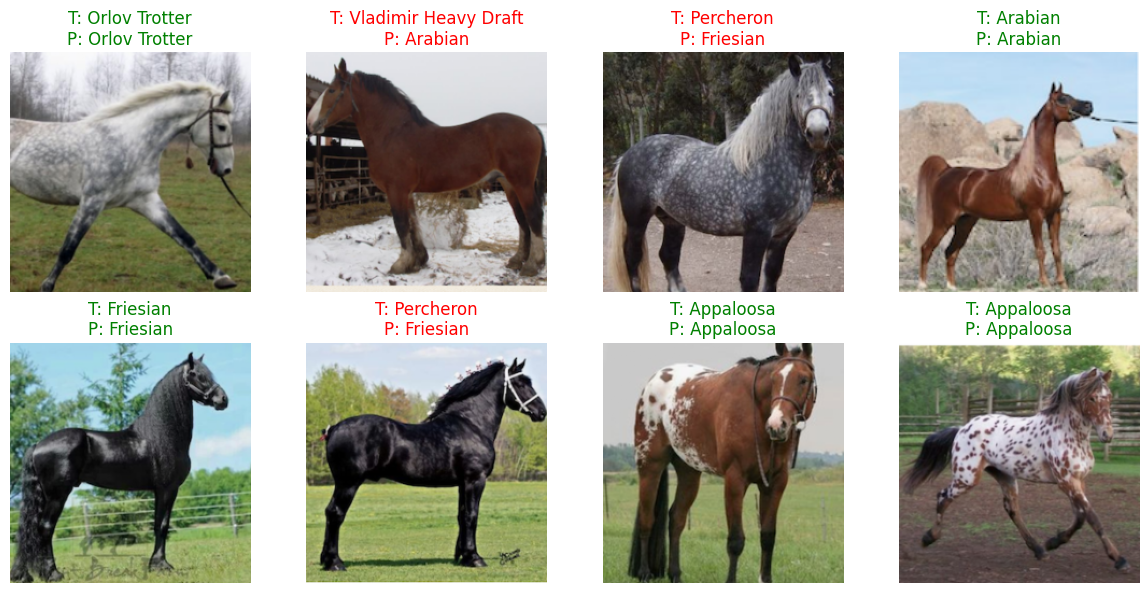

In [16]:
def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return tensor * std + mean

images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for idx, ax in enumerate(axes.flat):
    img = denormalize(images[idx].cpu()).permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    ax.imshow(img)
    true_label = breed_names[labels[idx]]
    pred_label = breed_names[preds[idx]]
    ax.set_title(f"T: {true_label}\nP: {pred_label}",
                 color=("green" if true_label == pred_label else "red"))
    ax.axis("off")

plt.tight_layout()
plt.show()

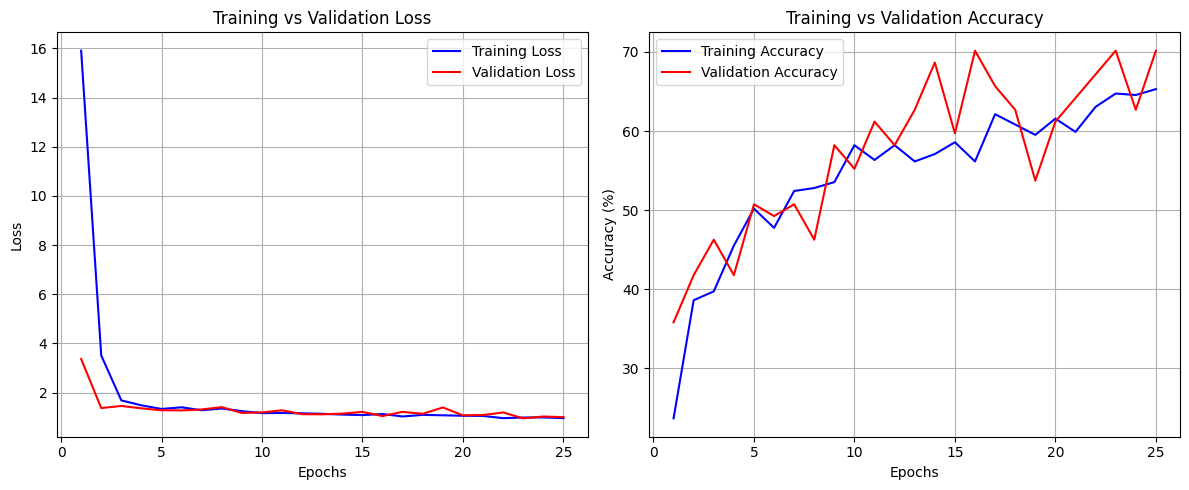

In [17]:
def plot_training_curves(history):

    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'r-', label='Validation Loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_accuracy'], 'b-', label='Training Accuracy')
    plt.plot(epochs, history['val_accuracy'], 'r-', label='Validation Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
plot_training_curves(history)

### Analyze the results
Is the model overfitting/underfitting?
Plot the training and validation loss/accuracy curves.

The training and validation curves show that the model is not overfitting,  
as both accuracies remain close, with the best validation accuracy reaching  
around 66%.

However, the model is mildly underfitting, plateauing around 60–66% accuracy.  
On the test set, performance is consistent (approximately 66% accuracy),  
which aligns well with the validation results.

The classification report reveals poor recognition of some minority classes,  
particularly Vladimir Heavy Draft and Percheron, due to class imbalance and  
the small size of the training set. This imbalance causes the model to favor  
majority classes while struggling to learn underrepresented ones.

To optimize performance, transfer learning with a pretrained backbone  
(e.g., ResNet or EfficientNet), combined with data augmentation and  
weighted loss, can help the model generalize better and improve recall  
for minority classes.

### Transfer Learning

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(weights='DEFAULT')

for param in model.parameters():
    param.requires_grad = False

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 7)
model = model.to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001, weight_decay=1e-4)

def one_epoch_training(model, train_loader, loss_function, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return running_loss / len(train_loader.dataset), 100.0 * correct / total

def one_epoch_validation(model, val_loader, loss_function, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_function(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return running_loss / len(val_loader.dataset), 100.0 * correct / total

def train_model(model, train_loader, val_loader, loss_function, optimizer, num_epochs, device, save_path="best_resnet_checkpoint.pth"):
    best_val_acc = 0.0
    for epoch in range(num_epochs):
        train_loss, train_acc = one_epoch_training(model, train_loader, loss_function, optimizer, device)
        val_loss, val_acc = one_epoch_validation(model, val_loader, loss_function, device)
        print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            checkpoint = {
                "epoch": epoch + 1,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "best_val_accuracy": best_val_acc
            }
            torch.save(checkpoint, save_path)
            print(f"Best model saved (Val Acc = {best_val_acc:.2f}%)")
    return model

num_epochs = 25
trained_model = train_model(model, train_loader, val_loader, loss_function, optimizer, num_epochs, device)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 177MB/s]


Epoch [1/25] | Train Loss: 1.7638, Train Acc: 30.78% | Val Loss: 1.4355, Val Acc: 47.76%
Best model saved (Val Acc = 47.76%)
Epoch [2/25] | Train Loss: 1.3431, Train Acc: 57.84% | Val Loss: 1.1075, Val Acc: 59.70%
Best model saved (Val Acc = 59.70%)
Epoch [3/25] | Train Loss: 1.1032, Train Acc: 66.79% | Val Loss: 0.8892, Val Acc: 76.12%
Best model saved (Val Acc = 76.12%)
Epoch [4/25] | Train Loss: 0.9539, Train Acc: 70.90% | Val Loss: 0.7640, Val Acc: 82.09%
Best model saved (Val Acc = 82.09%)
Epoch [5/25] | Train Loss: 0.8789, Train Acc: 74.63% | Val Loss: 0.7572, Val Acc: 77.61%
Epoch [6/25] | Train Loss: 0.7900, Train Acc: 76.87% | Val Loss: 0.6434, Val Acc: 82.09%
Epoch [7/25] | Train Loss: 0.7351, Train Acc: 80.22% | Val Loss: 0.5992, Val Acc: 82.09%
Epoch [8/25] | Train Loss: 0.6928, Train Acc: 80.97% | Val Loss: 0.5795, Val Acc: 83.58%
Best model saved (Val Acc = 83.58%)
Epoch [9/25] | Train Loss: 0.7007, Train Acc: 78.54% | Val Loss: 0.5349, Val Acc: 88.06%
Best model saved (V

### Load Best trained model

In [19]:
checkpoint = torch.load("/content/best_resnet_checkpoint.pth", map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### test the model on test set

Classification Report:

                      precision    recall  f1-score   support

          Akhal-Teke       0.77      0.83      0.80        12
           Appaloosa       0.91      1.00      0.95        10
       Orlov Trotter       0.62      0.45      0.53        11
Vladimir Heavy Draft       1.00      1.00      1.00         4
           Percheron       0.75      0.50      0.60         6
             Arabian       0.75      1.00      0.86        12
            Friesian       1.00      0.92      0.96        12

            accuracy                           0.82        67
           macro avg       0.83      0.81      0.81        67
        weighted avg       0.82      0.82      0.81        67



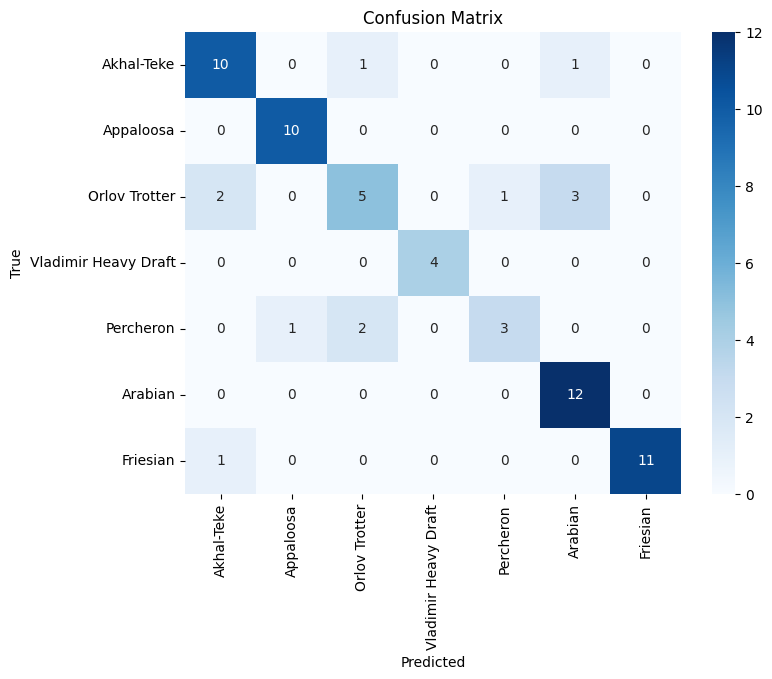

In [20]:
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=breed_names))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=breed_names, yticklabels=breed_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

### show some predictions with the images

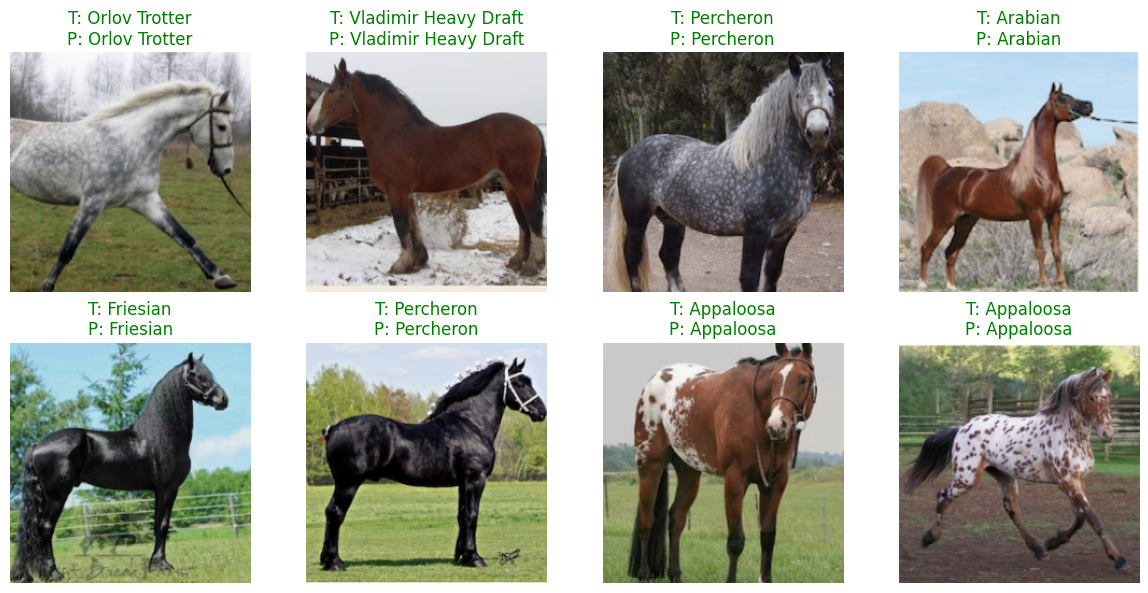

In [21]:
def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return tensor * std + mean

images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for idx, ax in enumerate(axes.flat):
    img = denormalize(images[idx].cpu()).permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    ax.imshow(img)
    true_label = breed_names[labels[idx]]
    pred_label = breed_names[preds[idx]]
    ax.set_title(f"T: {true_label}\nP: {pred_label}",
                 color=("green" if true_label == pred_label else "red"))
    ax.axis("off")

plt.tight_layout()
plt.show()